In [1]:
import json
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



data = []
with open("03_data/12_Sarcasm_bundle_archive/Sarcasm_Headlines_Dataset.json") as f:
    for line in f:
        data.append(json.loads(line))

sentences_data = []
labels_data =[]
urls_data = []
for item in data:
    sentences_data.append(item['headline'])
    labels_data.append(item['is_sarcastic'])
    urls_data.append(item['article_link'])
    
"""     
tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences_data)
padded = pad_sequences(sequences, padding='post')

#print(padded)
""" 

'     \ntokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")\ntokenizer.fit_on_texts(sentences_data)\nword_index = tokenizer.word_index\nsequences = tokenizer.texts_to_sequences(sentences_data)\npadded = pad_sequences(sequences, padding=\'post\')\n\n#print(padded)\n'

In [2]:
#train_ds, test_ds = tfds.load('mnist', split=['train', 'test'])

#we have 26000 records so we set 20000 to be train set and 6709 to be test set
training_size = 20000
training_sentences = sentences_data[0:training_size]
testing_sent = sentences_data[training_size:] 
training_label = labels_data[0:training_size]
testing_label = labels_data[training_size:]





In [4]:
len(sentences_data)

26709

In [3]:
def token(sentences):
    """
    This is typical NLP process.
    1.We use Tokenizer() to set condition about word-to-sequcen. num_words represent how many words will be reserver
    2.fit_on_text() let data(sentences or words) to fit this model. This will change tokenizer into a dictonary with tokenizer configuration.
      For instance, tokenizer.word_index = dict{'removed':3876} tokenizer.texts_to_sequence() = [234, 514] = tokenizer word
    3.If we want to get a dictionary with {'word':index}, you can use feature word_index to get that
    4.Fo now, we only translate corpus with numbers, each words in corps has its own number
    
    Parameters:
    -----------
    sentences:list
        This input is coming for typical json file and each sentences contain some english wrods
           
    Return:
    ----------
    tokenizer:tokenizer configurat
        python dict
    
    word_index:dictionary
        every word matchup dictionary
        
    sequences:list
        transfor every word into number according to tokenizer we generated before
        
    padded:list
        fill every sentence into same length with 0
    
    """
    #we only want most 10,000 frequncy word.Although we can vector 29567 vector from our courps. 
    #Because we care most frequncy words in this sentence. for example "to" "of" "in". Maybe they are stopwords which should be eliminate
    #When can see word_index is the integrated dictionary for {word:number} pair but, after texts_to_sequcens() we only get most frequcn 10000
    vocab_size = 20000
    
    #max_lenght define the max lenght of each sentence. Because the length of sentence is unbalance, we should ignore that too long part
    #after define this parameter, we also define the column of input matrix, which will be (No.examples , max_length)
    max_length = 100
    
    #only keep most frequcey {vocab_size} words in croups
    #tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    
    #transfor sentence to number vector
    tokenizer.fit_on_texts(sentences)
    
    #a = tokenizer.tranform(sten)
    
    #get the index of each indivudule word
    word_index = tokenizer.word_index
    
    #only choose most frequency 10,000 word_index and transfrom sentences with them into number vector like[564, 452, 23, 1]
    #the out of vocabulary wiht be give 1. Maximize number of texts_to_sequences() will be 9999, which means the 10000th frequceny will 
    #not show in this sequcen
    sequences = tokenizer.texts_to_sequences(sentences)
    
    #maintain the sentence into same length
    #padded = pad_sequences(sequences)
    #If you want zero at the end, using padding='post'
    padded = pad_sequences(sequences, padding='post', maxlen=max_length, truncating='post')
    
    return tokenizer, word_index,sequences, padded

In [4]:
def split_data(sentences_data, labels_data, size):
    """
    This is demo part
    Input:
        the number of training example
    Output:
        train_x, test_x, train_y, test_y
    """
    training_size = size
    training_sentences = sentences_data[0:training_size]
    testing_sentences = sentences_data[training_size:] 
    training_label = labels_data[0:training_size]
    testing_label = labels_data[training_size:]
    
    return training_sentences, testing_sentences, training_label, testing_label
    

In [5]:
def embed_mod(training_padded, training_labels, word_index, testing_padded, testing_labels):
    """
    Paramters:
    ---------
    padded matrix:array_like
        
        
    Return:
    ---------
    
    
    """
    #vocab_size is the max integer word vector plus 1
    vocab_size = training_padded.max()+1
    #output layers of firts embedding layer
    embedding_dim = 32
    max_length = training_padded.shape[1]
    num_epochs = 30
    
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    history = model.fit(training_padded, \
                        training_labels, \
                        epochs = num_epochs, \
                        validation_data = (testing_padded, testing_labels), \
                        verbose = 2
                       )
    
    return model, history

In [6]:
if __name__=='__main__':
    
    training_sentences, testing_sentences, training_labels, testing_labels = split_data(sentences_data, labels_data, training_size)
    tokenizer, word_index_train, training_seq, training_padded = token(training_sentences)
    _, word_index_test, _, testing_padded = token(testing_sentences)
    
    vocab_size = training_padded.shape[1]
    
    training_padded = np.array(training_padded)
    training_labels = np.array(training_labels)
    testing_padded = np.array(testing_padded)
    testing_labels = np.array(testing_labels)
    
    model, history = embed_mod(training_padded, training_labels, word_index_train, testing_padded, testing_labels)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                792       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 640,817
Trainable params: 640,817
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 7s - loss: 0.6297 - accuracy: 0.6338 - val_loss: 0.6615 - val_accuracy: 0.5855
Epoch 2/30
20000/20000 - 5s - loss: 0.3589 - accuracy: 0.8578 - val_loss: 0.8371 - val_accuracy

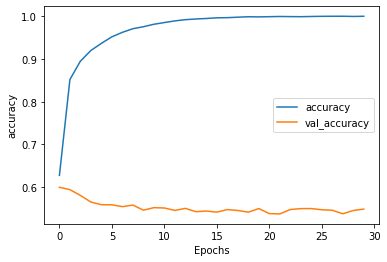

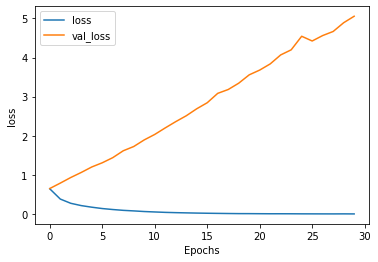

In [55]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [56]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
print(model.predict(padded))

[[9.9515307e-01]
 [8.5634895e-09]]


In [278]:
type(training_padded)

numpy.ndarray

In [280]:
t_p = np.array(training_padded)

In [281]:
type(t_p)

numpy.ndarray

In [270]:
_, history = embed_mod(training_padded, training_label, word_index, testing_padded, testing_label)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

In [206]:
word_index[list(word_index)[-1]]

29657

In [247]:
training_padded.shape

(20000, 40)

In [199]:
testing_padded.shape

(20000, 40)

In [31]:
sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!'
]

tokenizer = Tokenizer(num_words = 100)

tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

print(type(word_index))



sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

import tensorflow as tf
import numpu as np 
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def token(sentences):
    """
    Input:
        sentcens in list type
    Outpu:
        dictionary with tokenizer configure, like.word_index = dict = {'words', 'index'}
    """
    #only keep most frequcey 100 words in croups
    #tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
    tokenizer = Tokenizer(num_words=1, oov_token="<OOV>")
    tokenizer.fit_on_texts(sentences)
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(sentences)
    #maintain the sentence into same length
    #padded = pad_sequences(sequences)
    #If you want zero at the end, using padding='post'
    padded = pad_sequences(sequences, padding='post')
    
    return tokenizer, word_index,sequences, padded

In [145]:
token, word_index, seq, padded = token(sentences_data)

In [149]:
padded

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [146]:
print(padded)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [288]:
vocab_size = training_padded.max()+1
    #output layers of firts embedding layer
embedding_dim = 16
max_length = training_padded.shape[1]
num_epochs = 30
    
    
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
    

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_14  (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [290]:
_, history = embed_mod(training_padded, training_labels, word_index, testing_padded, testing_labels)

Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 170us/sample - loss: 0.6683 - accuracy: 0.5793
Epoch 2/10
 8192/20000 [===========>..................] - ETA: 1s - loss: 0.5037 - accuracy: 0.8075

KeyboardInterrupt: 

In [ ]:
v

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

mnist = tf.keras.datasets.mnist

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

predictions = model(x_train[:1]).numpy()
predictions

tf.nn.softmax(predictions).numpy()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_fn(y_train[:1], predictions).numpy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

In [47]:
seq

[[4, 2, 1, 3], [4, 2, 1, 6], [5, 2, 1, 3], [7, 5, 8, 1, 3, 9, 10]]

In [48]:
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

In [76]:
token_1, word_index_1, seq_1 = token(sentences)

In [77]:
test_seq = token_1.texts_to_sequences(test_data)

In [78]:
test_seq

[[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]

In [79]:
word_index_2 = token_1.word_index

In [80]:
word_index_2

{'<OOV>': 1,
 'my': 2,
 'love': 3,
 'dog': 4,
 'i': 5,
 'you': 6,
 'cat': 7,
 'do': 8,
 'think': 9,
 'is': 10,
 'amazing': 11}

In [52]:
word_index_1

{'my': 1, 'dog': 2, 'i': 3, 'really': 4, 'love': 5, 'loves': 6, 'manatee': 7}

In [53]:
seq_1

[[3, 4, 5, 1, 2], [1, 2, 6, 1, 7]]

In [107]:
len(sentences_data)

26709

In [124]:
sentences_data[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

In [99]:
len(labels)

26709

In [100]:
len(urls)

26709

In [131]:
token, index, seq, padded = token(sentences_data)

In [110]:
padded[0]

array([  308, 15115,   679,  3337,  2298,    48,   382,  2576, 15116,
           6,  2577,  8434,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

In [111]:
padded.shape

(26709, 40)

In [112]:
seq[0]

[308, 15115, 679, 3337, 2298, 48, 382, 2576, 15116, 6, 2577, 8434]

In [132]:
index

{'<OOV>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'this': 19,
 'by': 20,
 'after': 21,
 'up': 22,
 'out': 23,
 'be': 24,
 'how': 25,
 'as': 26,
 'it': 27,
 'that': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'his': 32,
 'what': 33,
 'he': 34,
 'all': 35,
 'just': 36,
 'who': 37,
 'has': 38,
 'will': 39,
 'more': 40,
 'one': 41,
 'into': 42,
 'report': 43,
 'year': 44,
 'why': 45,
 'have': 46,
 'area': 47,
 'over': 48,
 'donald': 49,
 'u': 50,
 'day': 51,
 'says': 52,
 's': 53,
 'can': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'like': 58,
 'her': 59,
 "trump's": 60,
 'old': 61,
 'no': 62,
 'get': 63,
 'off': 64,
 'an': 65,
 'life': 66,
 'people': 67,
 'obama': 68,
 'now': 69,
 'house': 70,
 'still': 71,
 "'": 72,
 'women': 73,
 'make': 74,
 'was': 75,
 'than': 76,
 'white': 77,
 'back': 78,
 'my': 79,
 'i': 80,
 'clinton': 81,
 '

In [3]:
n_1 = np.array([1,2,3])

In [4]:
type(n_1)

numpy.ndarray

In [5]:
n_1.shape

(3,)

In [7]:
np.sum(n_1, axis=0)

6

In [8]:
print(np.array([1,2,3]))

[1 2 3]


In [9]:
print(np.array([1,2,3]).T)

[1 2 3]


In [11]:
x = np.random.random((3,4))

In [12]:
x


array([[0.88442187, 0.23795931, 0.98513482, 0.45393277],
       [0.56744453, 0.72770561, 0.05958783, 0.29043551],
       [0.22937902, 0.53647065, 0.78858252, 0.66278646]])

In [13]:
y = np.random.random((3,1))

In [14]:
y

array([[0.99079802],
       [0.14517528],
       [0.14981482]])

In [15]:
z = np.random.random((1,4))

In [16]:
z

array([[0.43804182, 0.82728974, 0.21750981, 0.42979067]])

In [18]:
a = x+y

In [20]:
a

array([[1.87521989, 1.22875733, 1.97593284, 1.44473079],
       [0.71261981, 0.87288088, 0.20476311, 0.43561079],
       [0.37919383, 0.68628547, 0.93839734, 0.81260128]])

In [21]:
b = y+y.T

In [22]:
b


array([[1.98159605, 1.1359733 , 1.14061284],
       [1.1359733 , 0.29035055, 0.29499009],
       [1.14061284, 0.29499009, 0.29962963]])

In [23]:
x

array([[0.88442187, 0.23795931, 0.98513482, 0.45393277],
       [0.56744453, 0.72770561, 0.05958783, 0.29043551],
       [0.22937902, 0.53647065, 0.78858252, 0.66278646]])

In [24]:
np.allclose(x,0)

False

In [59]:
####!conda install -c anaconda tensorflow-datasets -y

In [61]:
import io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

In [78]:
#we transfrom input as 1000 column vecter (only can represent 999 words)
#5 is the output dimension
embedding_layer = layers.Embedding(1000, 5)

In [79]:
#we create a (3,) column vector as input
result = embedding_layer(tf.constant([1,2,3,4]))

In [80]:
print(result.numpy())
print(result.shape)

[[ 0.01711133 -0.010478   -0.04752811  0.044742    0.04195086]
 [-0.02242355  0.00757224 -0.0406887   0.0210263  -0.03903691]
 [ 0.01967318  0.03420434 -0.04607034  0.02640963 -0.04489746]
 [-0.01534332  0.04902101 -0.04665446  0.00828029 -0.03966467]]
(4, 5)


In [82]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', \
                                         split=(tfds.Split.TRAIN, tfds.Split.TEST), \
                                         with_info=True, \
                                         as_supervised=True
                                         )

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to C:\Users\etern\tensorflow_datasets\imdb_reviews\subwords8k\0.1.0. Subsequent calls will reuse this data.

In [83]:
encoder = info.features['text'].encoder

In [ ]:
print